In [ ]:
library(devtools)
install_github("r3fang/SnapATAC")

# library

In [ ]:
library(SnapATAC)
library("GenomicRanges")
library(Matrix)
library(Seurat)

# annotation

In [11]:
black_list <- read.table('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/data/matrix/mm10.blacklist.bed.gz')
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [27]:
metadata <- read.csv('example/histone/data/matrix/meta_with_source.tsv', sep='\t', row.names = 1)

In [35]:
metadata <- metadata[which(metadata$Target == 'ATAC'),]

In [49]:
runSnapATAC <- function(x.sp, metadata = metadata, binary = FALSE, black_list = black_list.gr){
    if(binary == TRUE){
        x.sp = makeBinary(x.sp, mat="bmat")
    }
    # remove black list
#     idy = queryHits(
#         findOverlaps(x.sp@feature, black_list)
#       );
#     if(length(idy) > 0){
#         x.sp = x.sp[,-idy, mat="bmat"];
#       };
    # remove chrM
#     chr.exclude = seqlevels(x.sp@feature)[grep("random|chrM", seqlevels(x.sp@feature))]
#     idy = grep(paste(chr.exclude, collapse="|"), x.sp@feature)
#     if(length(idy) > 0){
#         x.sp = x.sp[,-idy, mat="bmat"]
#       };
    # cal bin coverage
    bin.cov = log10(Matrix::colSums(x.sp@bmat)+1);
#     hist(
#         bin.cov[bin.cov > 0], 
#         xlab="log10(bin cov)", 
#         main="log10(Bin Cov)", 
#         col="lightblue", 
#         xlim=c(0, 5)
#       );
    bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95)
    idy = which(bin.cov <= bin.cutoff & bin.cov > 0)
    x.sp = x.sp[, idy, mat="bmat"];
    # processing
    x.sp = runDiffusionMaps(
        obj=x.sp,
        input.mat="bmat", 
        num.eigs=50
      );
    x.sp = runKNN(
        obj=x.sp,
        eigs.dims=1:20,
        k=15
      );
    x.sp=runCluster(
        obj=x.sp,
        tmp.folder=tempdir(),
        louvain.lib="R-igraph",
        seed.use=10
      );
    tmpmeta = data.frame(x.sp@barcode, metadata[x.sp@barcode,'Annotation'],  metadata[x.sp@barcode,'Tissue'], metadata[x.sp@barcode,'H3K27ac'], metadata[x.sp@barcode,'H3K4me1'], row.names = x.sp@barcode)
    colnames(tmpmeta) <- c('barcode', 'annotation', 'tissue', 'H3K27ac', 'H3K4me1')
    x.sp@metaData <- tmpmeta
    x.sp@metaData$cluster = x.sp@cluster
    plotDimReductPW(
        obj=x.sp, 
        eigs.dims=1:50,
        point.size=0.3,
        point.color="grey",
        point.shape=19,
        point.alpha=0.6,
        down.sample=5000,
        pdf.file.name=NULL, 
        pdf.height=7, 
        pdf.width=7
      )
    x.sp = runViz(
        obj=x.sp, 
        tmp.folder=tempdir(),
        dims=2,
        eigs.dims=1:10, 
        method="umap",
        seed.use=10
      )
}

# H3K27ac

In [18]:
mm = readMM('example/histone/data/matrix/04.Paired-Tag_H3K27ac_DNA_filtered_matrix/matrix.mtx')
bc = read.csv('example/histone/data/matrix/04.Paired-Tag_H3K27ac_DNA_filtered_matrix/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/data/matrix/04.Paired-Tag_H3K27ac_DNA_filtered_matrix/bins.tsv', sep = '\t', header = FALSE)$V1)

In [110]:
k27ac.sp <- createSnapFromBmat(t(as.sparse(mm)), barcodes = bc, bins = bin)

In [ ]:
k27ac.sp <- runSnapATAC(k27ac.sp)

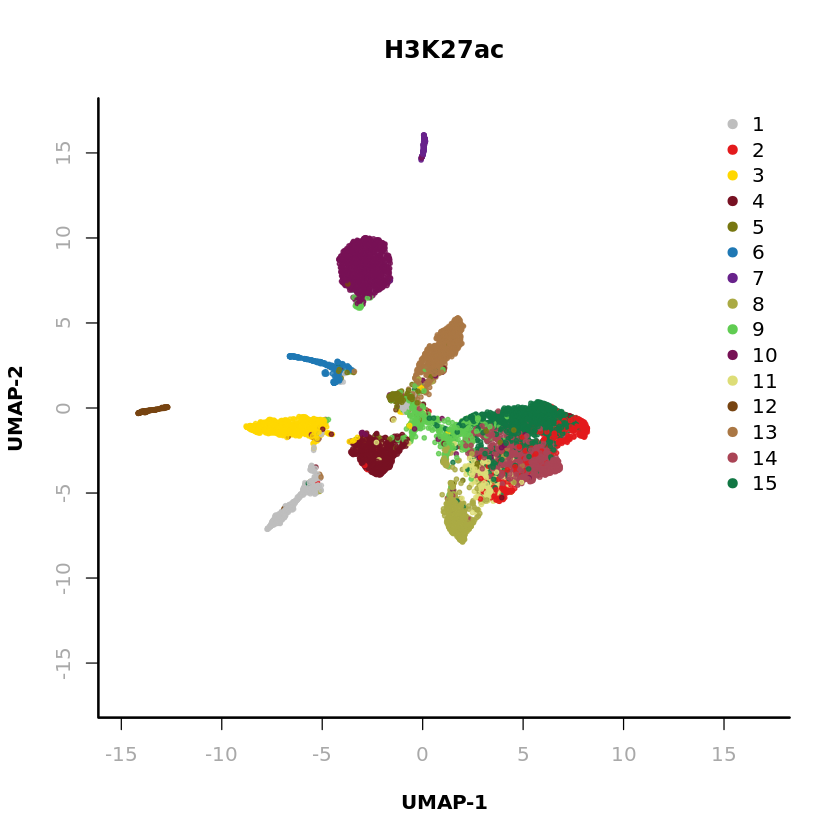

In [140]:
plotViz(
    obj=k27ac.sp,
    method="umap", 
    main="H3K27ac Cluster",
    point.color=k27ac.sp@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

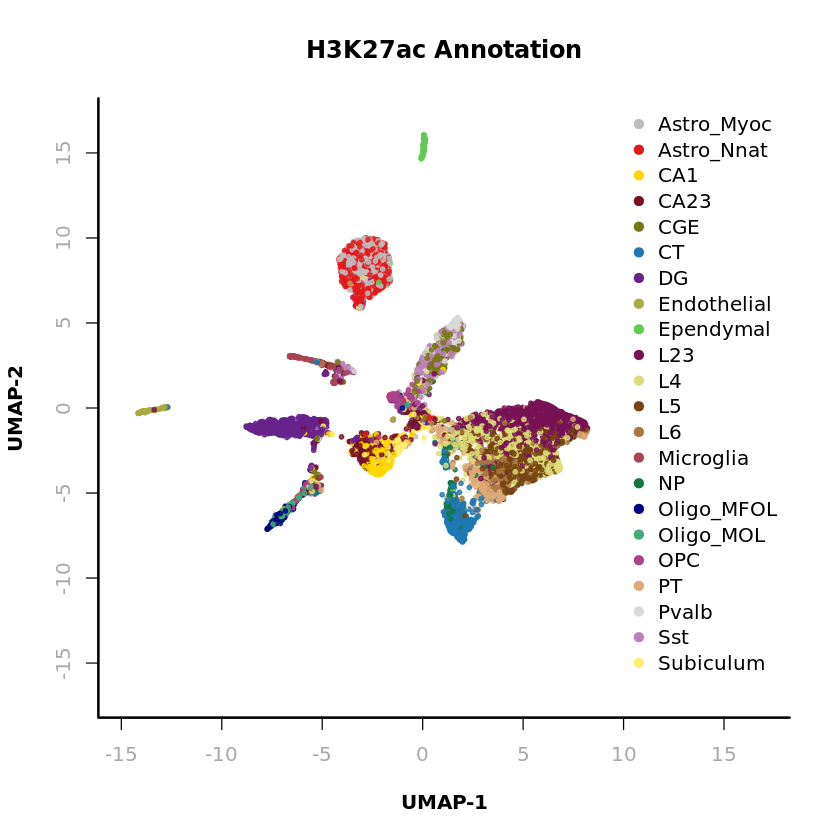

In [196]:
plotViz(
    obj=k27ac.sp,
    method="umap", 
    main="H3K27ac Annotation",
    point.color=k27ac.sp@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

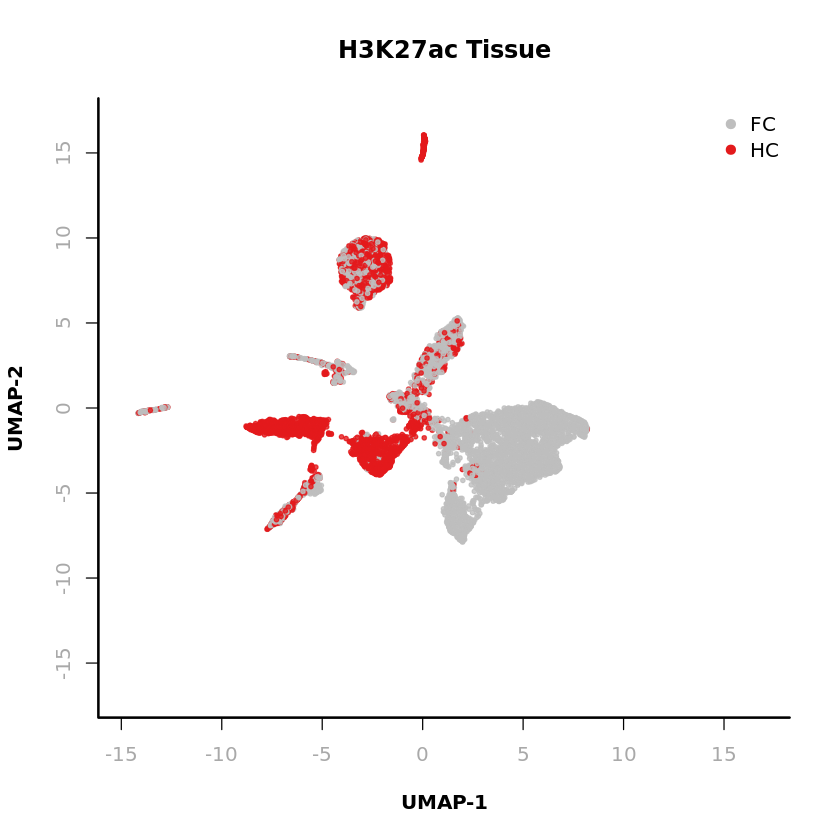

In [191]:
plotViz(
    obj=k27ac.sp,
    method="umap", 
    main="H3K27ac Tissue",
    point.color=k27ac.sp@metaData$tissue, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

# imputed H3K27ac

In [66]:
mm = readMM('example/histone/SCRIPT/imputation/mtx_imputed_H3K27ac/matrix.mtx')
bc = read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K27ac/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K27ac/bins.tsv', sep = '\t', header = FALSE)$V1)

In [67]:
bin = GRanges(read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K27ac/bins.tsv', sep = '\t', header = FALSE)$V1)

In [68]:
k27ac.impute <- createSnapFromBmat(as.sparse(mm), barcodes = bc, bins = bin)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



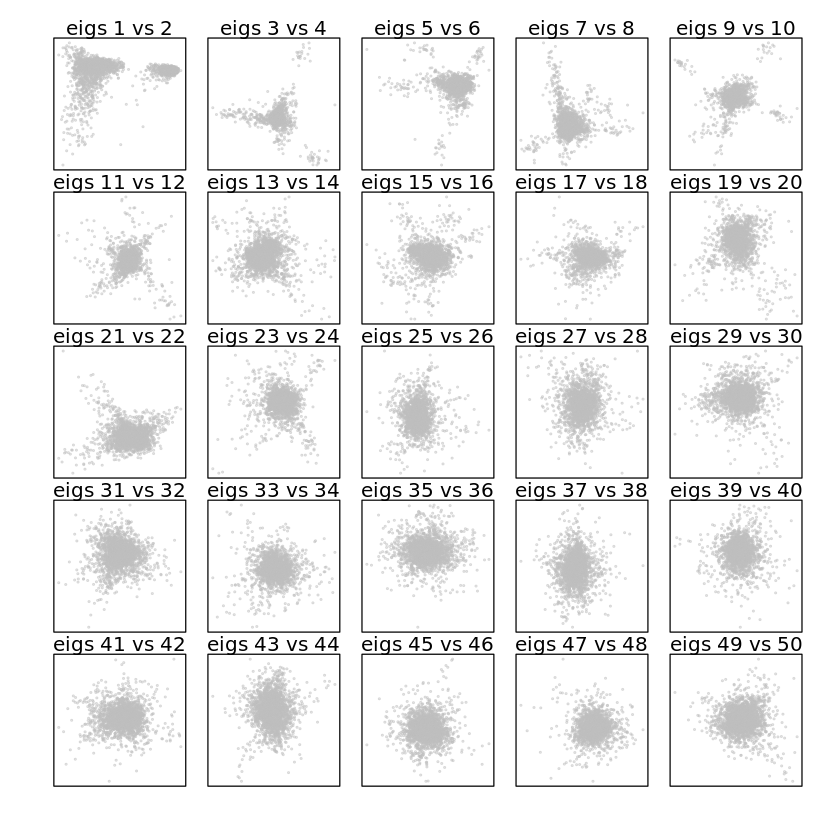

In [70]:
k27ac.impute <- runSnapATAC(k27ac.impute, metadata)

In [71]:
k27ac.impute

number of barcodes: 14095
number of bins: 49135
number of genes: 0
number of peaks: 0
number of motifs: 0

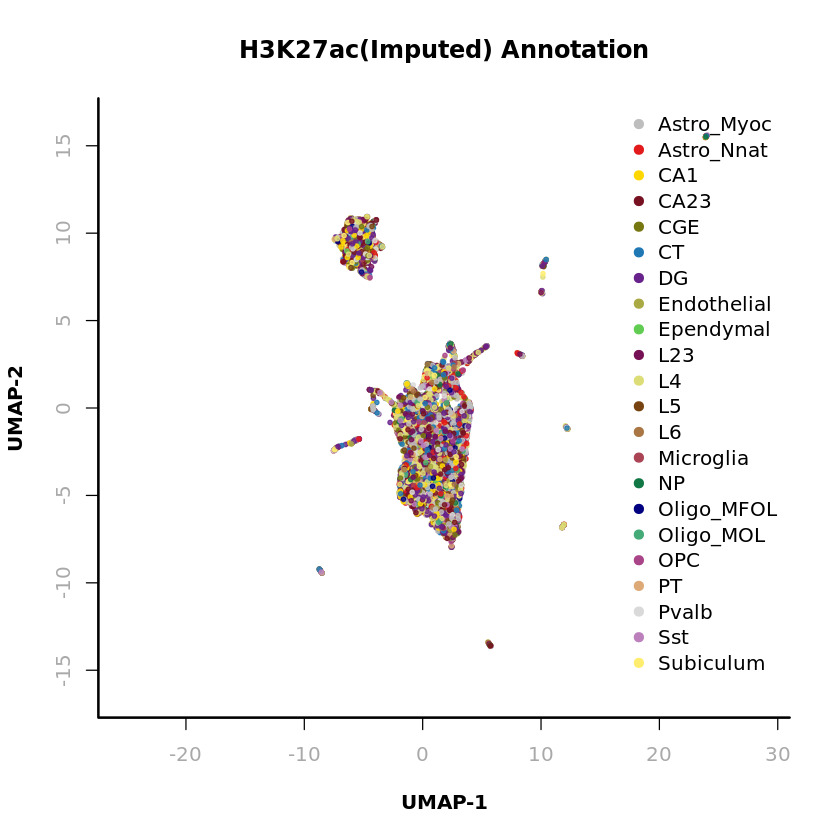

In [72]:
plotViz(
    obj=k27ac.impute,
    method="umap", 
    main="H3K27ac(Imputed) Annotation",
    point.color=k27ac.impute@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

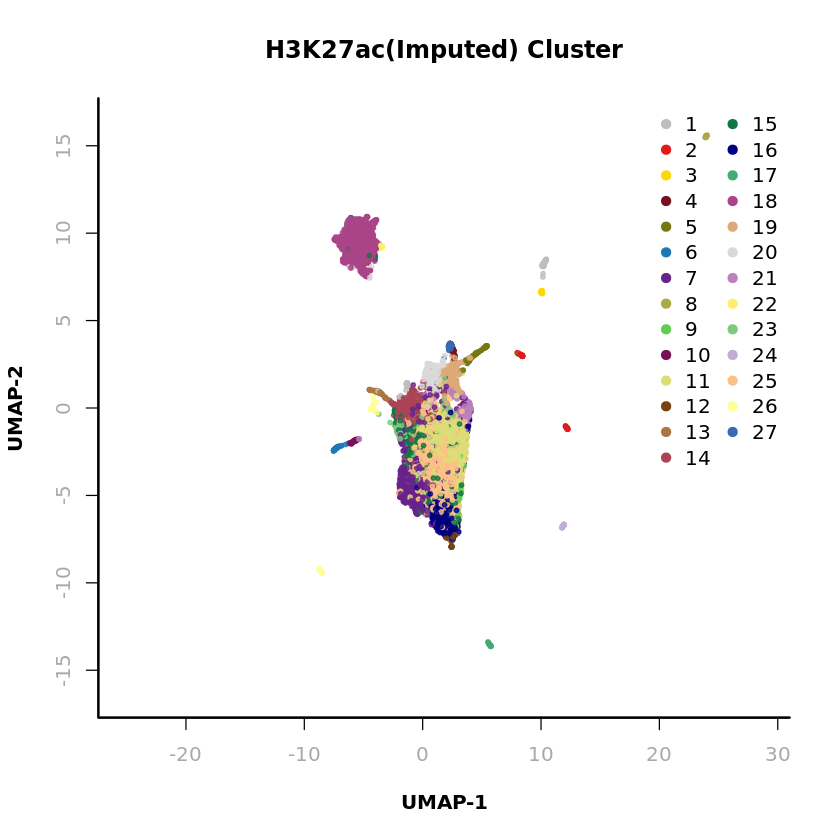

In [79]:
plotViz(
    obj=k27ac.impute,
    method="umap", 
    main="H3K27ac(Imputed) Cluster",
    point.color=k27ac.impute@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

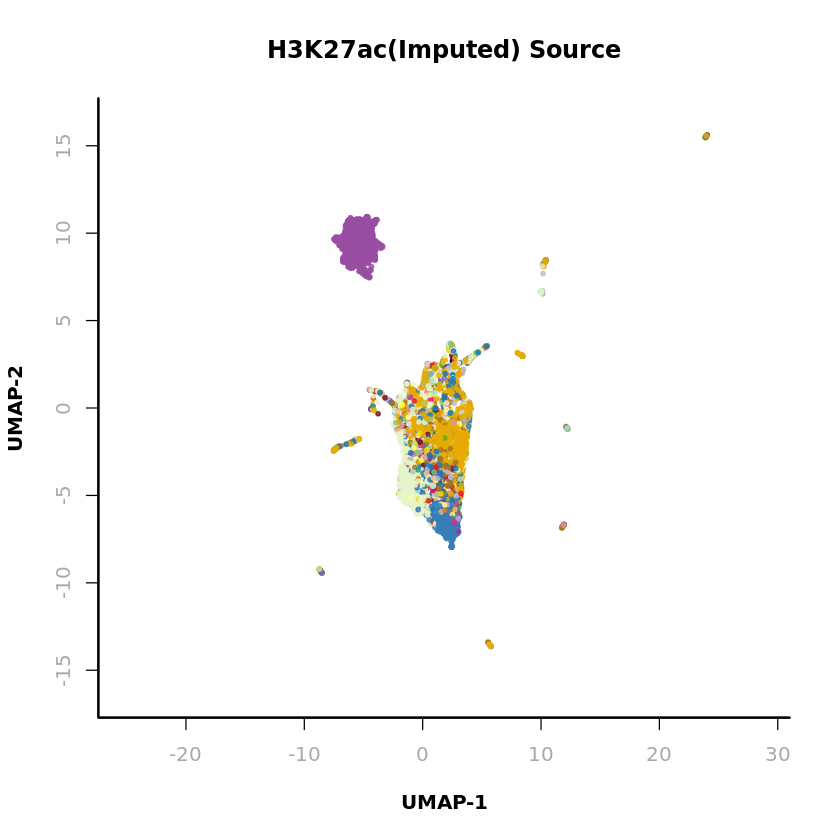

In [78]:
plotViz(
    obj=k27ac.impute,
    method="umap", 
    main="H3K27ac(Imputed) Source",
    point.color=k27ac.impute@metaData$H3K27ac, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=FALSE,
    legend.pos='right',
  )

# H3K4me1

In [15]:
mm = readMM('example/histone/data/matrix/02.Paired-Tag_H3K4me1_DNA_filtered_matrix/matrix.mtx')
bc = read.csv('example/histone/data/matrix/02.Paired-Tag_H3K4me1_DNA_filtered_matrix/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/data/matrix/02.Paired-Tag_H3K4me1_DNA_filtered_matrix/bins.tsv', sep = '\t', header = FALSE)$V1)

In [16]:
k4me1.sp <- createSnapFromBmat(t(as.sparse(mm)), barcodes = bc, bins = bin)

In [67]:
bin.cov = log10(Matrix::colSums(k4me1.sp@bmat)+1);

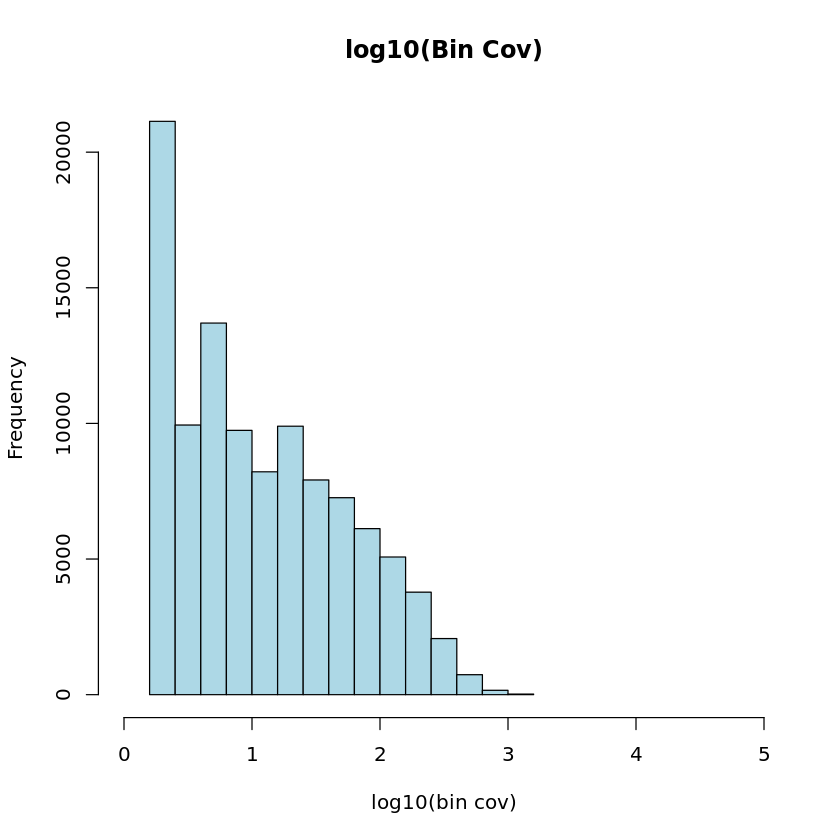

In [69]:
hist(   bin.cov[bin.cov > 0], 
        xlab="log10(bin cov)", 
        main="log10(Bin Cov)", 
        col="lightblue", 
        xlim=c(0, 5)
      );

In [ ]:
k4me1.sp <- runSnapATAC(k4me1.sp, metadata)

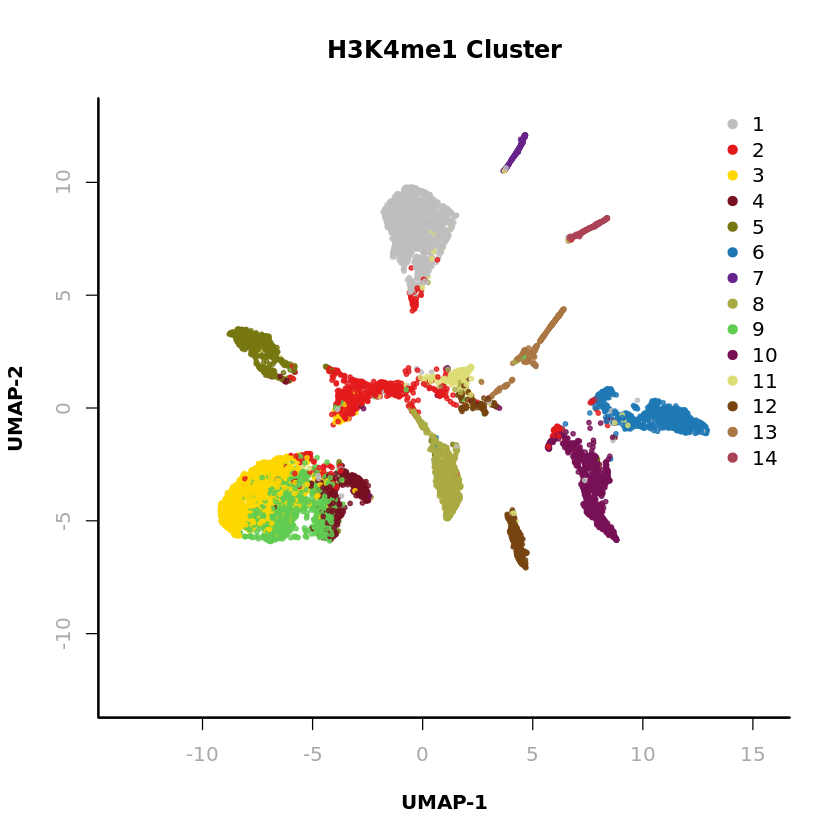

In [208]:
plotViz(
    obj=k4me1.sp,
    method="umap", 
    main="H3K4me1 Cluster",
    point.color=k4me1.sp@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

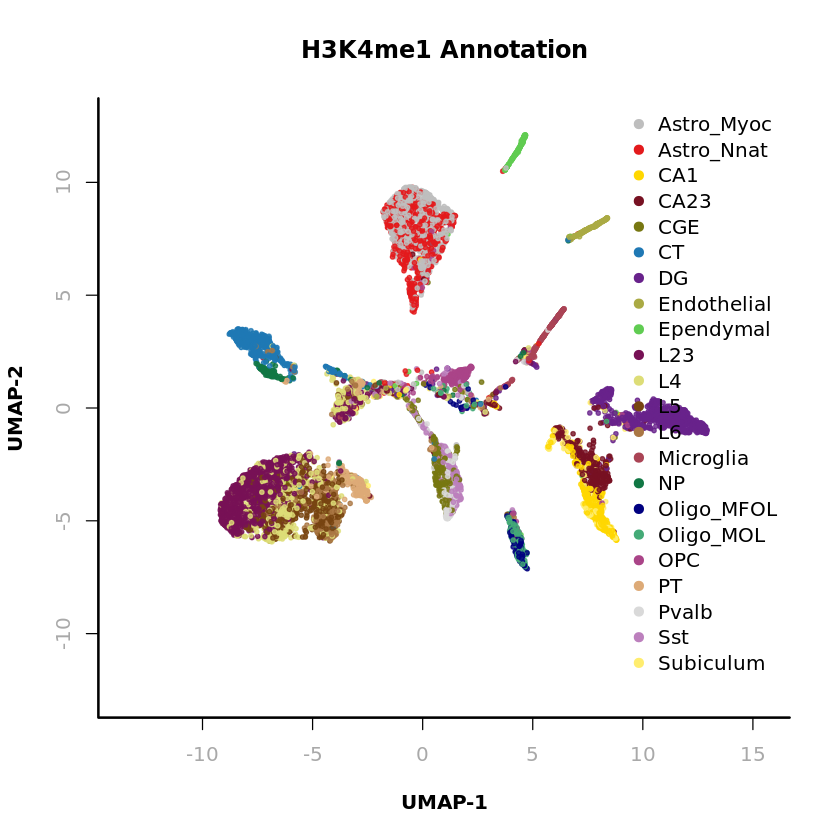

In [209]:
plotViz(
    obj=k4me1.sp,
    method="umap", 
    main="H3K4me1 Annotation",
    point.color=k4me1.sp@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

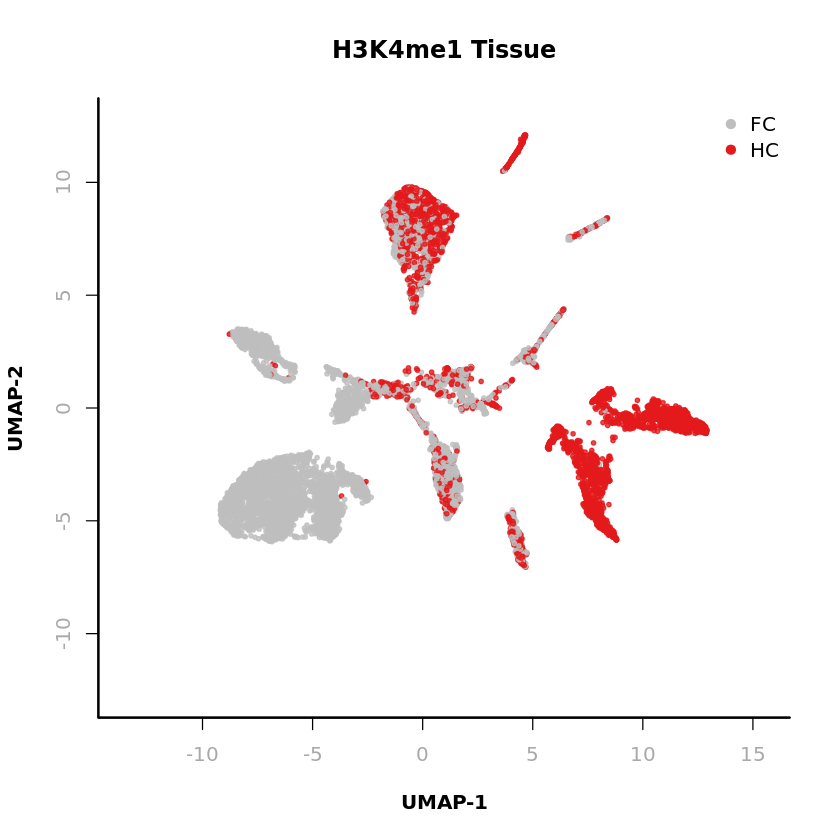

In [210]:
plotViz(
    obj=k4me1.sp,
    method="umap", 
    main="H3K4me1 Tissue",
    point.color=k4me1.sp@metaData$tissue, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

# imputed H3K4me1

In [29]:
mm = readMM('example/histone/SCRIPT/imputation/mtx_imputed_H3K4me1/matrix.mtx')
bc = read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K4me1/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/SCRIPT/imputation/mtx_imputed_H3K4me1/bins.tsv', sep = '\t', header = FALSE)$V1)

In [40]:
k4me1.impute <- createSnapFromBmat(as.sparse(mm), barcodes = bc, bins = bin)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



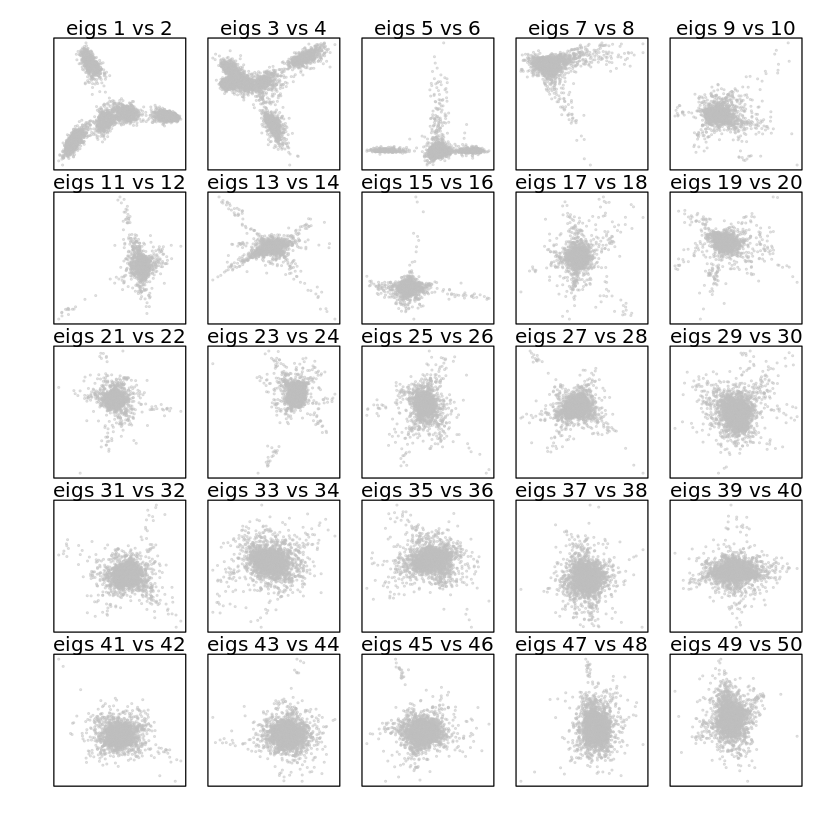

In [50]:
k4me1.impute <- runSnapATAC(k4me1.impute, metadata, binary = FALSE)

In [51]:
k4me1.impute

number of barcodes: 14095
number of bins: 100506
number of genes: 0
number of peaks: 0
number of motifs: 0

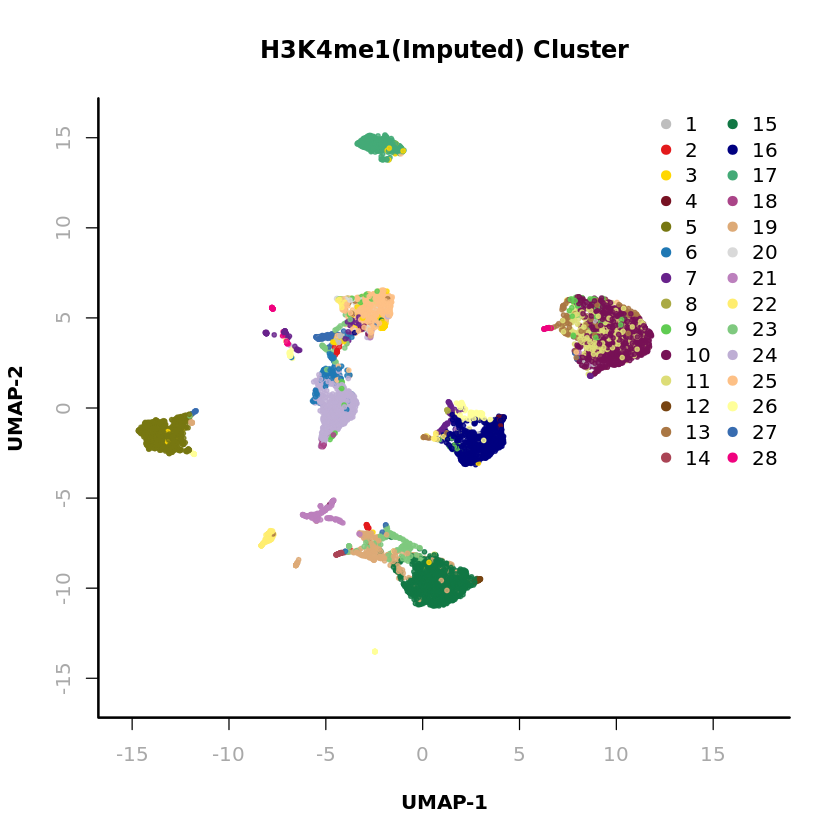

In [52]:
plotViz(
    obj=k4me1.impute,
    method="umap", 
    main="H3K4me1(Imputed) Cluster",
    point.color=k4me1.impute@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

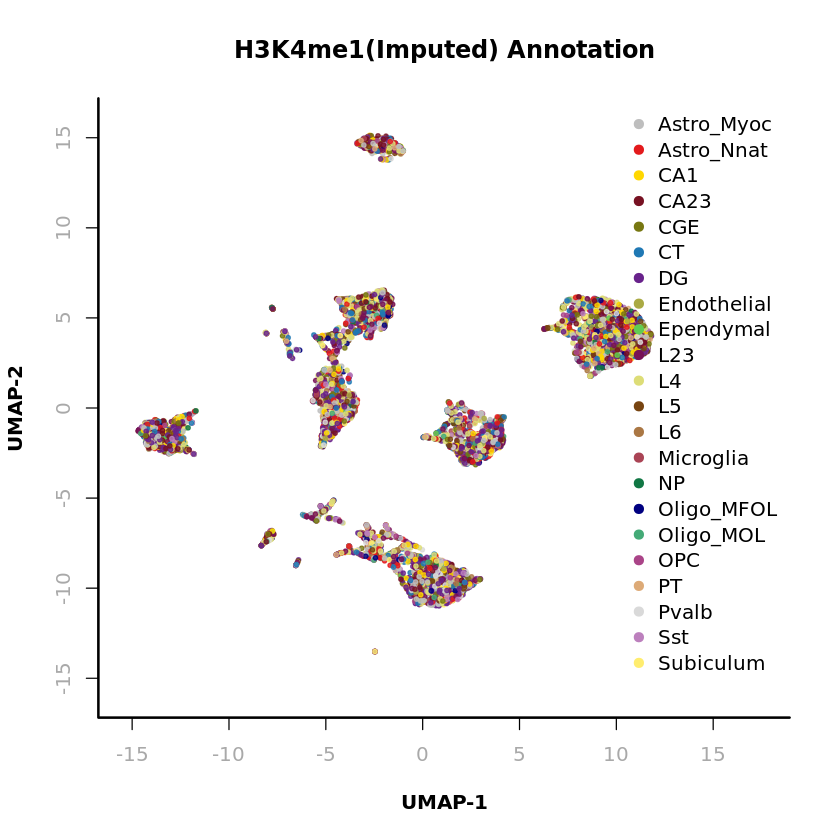

In [53]:
plotViz(
    obj=k4me1.impute,
    method="umap", 
    main="H3K4me1(Imputed) Annotation",
    point.color=k4me1.impute@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

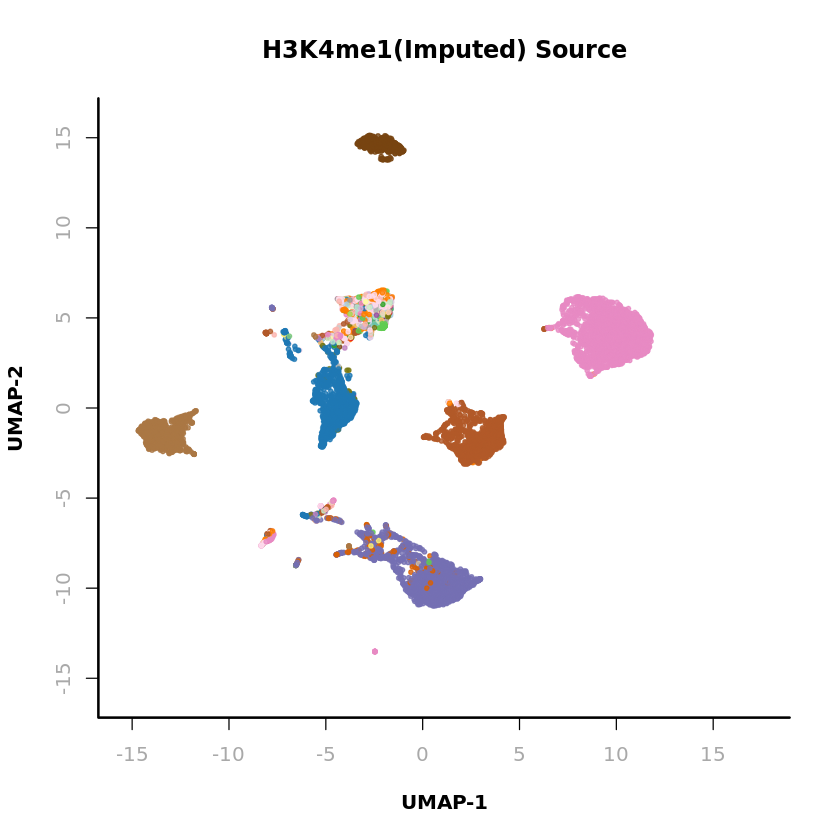

In [58]:
plotViz(
    obj=k4me1.impute,
    method="umap", 
    main="H3K4me1(Imputed) Source",
    point.color=k4me1.impute@metaData$H3K4me1, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='bottomleft',
  )

In [ ]:
?plotViz

# H3K4me3

In [211]:
mm = readMM('example/histone/data/matrix/03.Paired-Tag_H3K4me3_DNA_filtered_matrix/matrix.mtx')
bc = read.csv('example/histone/data/matrix/03.Paired-Tag_H3K4me3_DNA_filtered_matrix/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/data/matrix/03.Paired-Tag_H3K4me3_DNA_filtered_matrix/bins.tsv', sep = '\t', header = FALSE)$V1)

In [213]:
K4me3.sp <- createSnapFromBmat(t(as.sparse(mm)), barcodes = bc, bins = bin)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



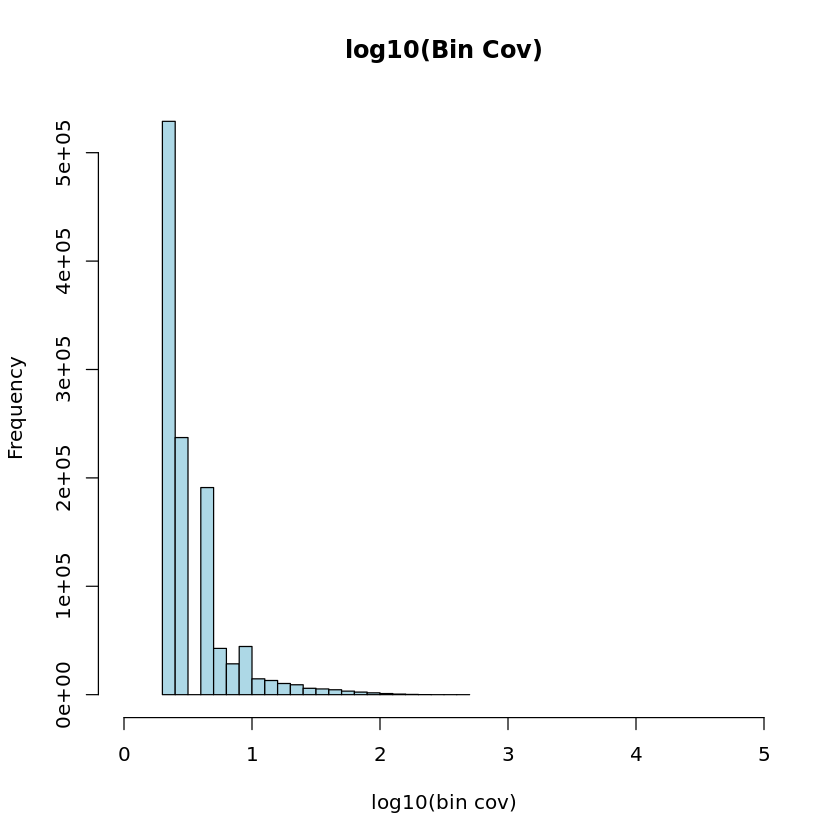

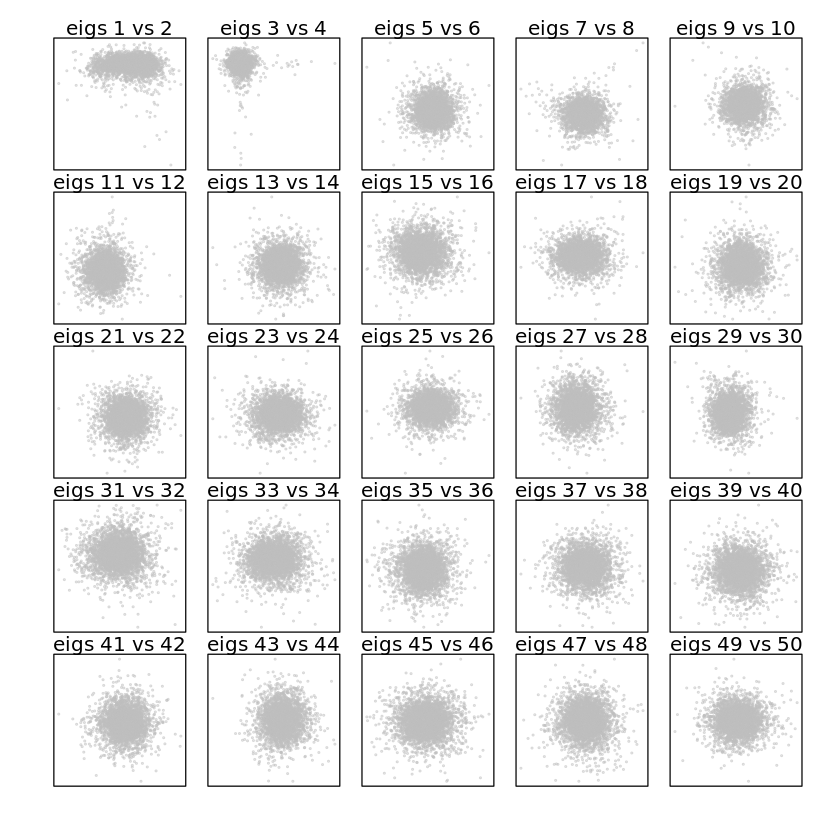

In [215]:
K4me3.sp <- process(K4me3.sp, metadata)

In [222]:
length(K4me3.sp@cluster)

[1] 7465

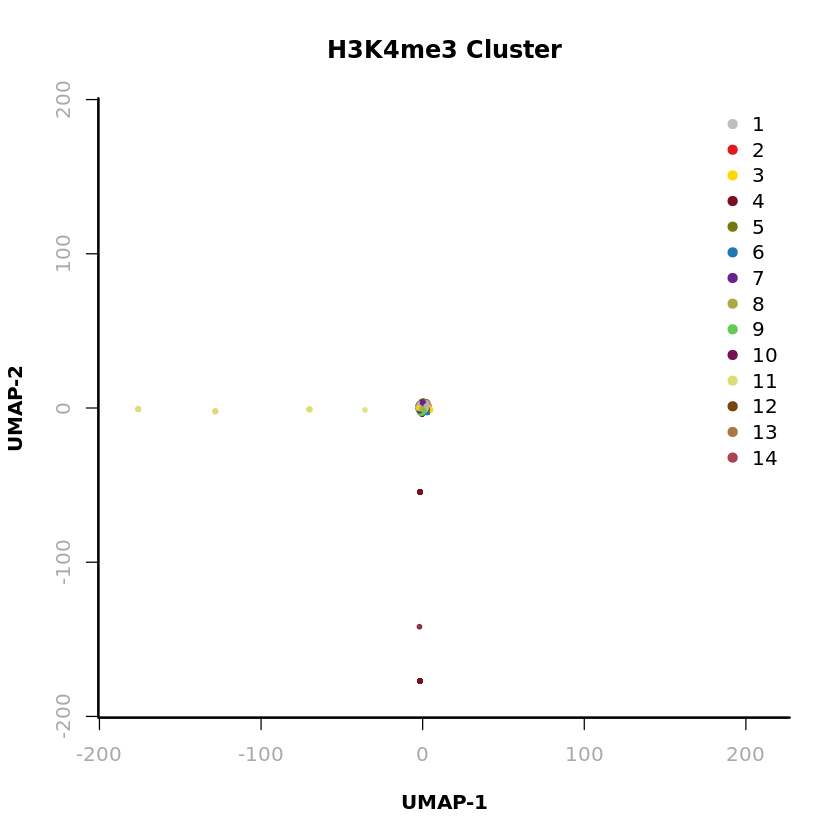

In [223]:
plotViz(
    obj=K4me3.sp,
    method="umap", 
    main="H3K4me3 Cluster",
    point.color=K4me3.sp@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

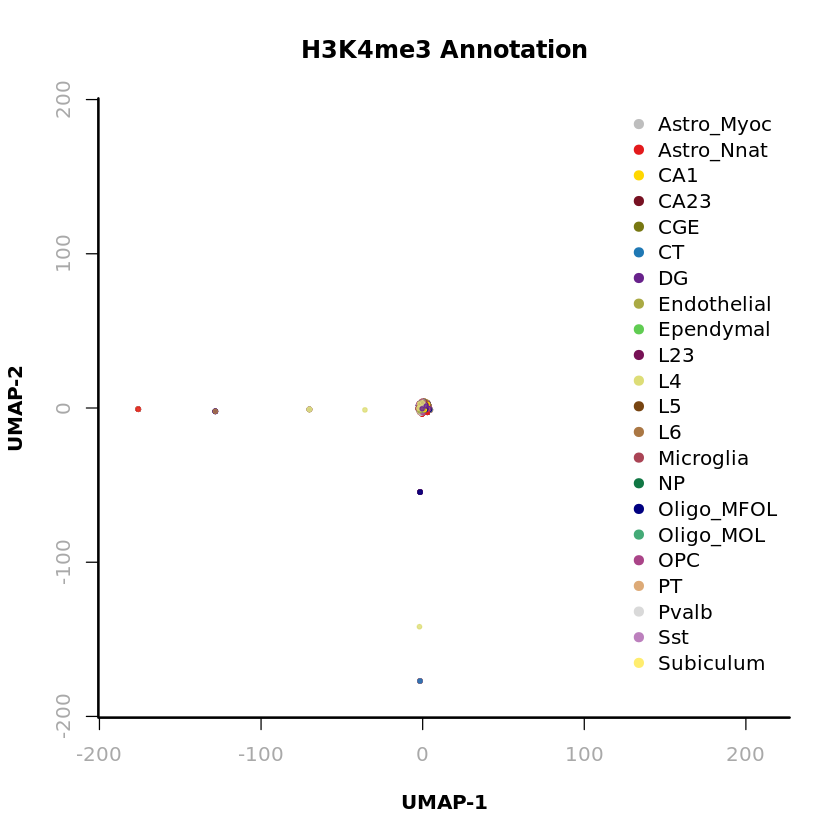

In [224]:
plotViz(
    obj=K4me3.sp,
    method="umap", 
    main="H3K4me3 Annotation",
    point.color=K4me3.sp@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

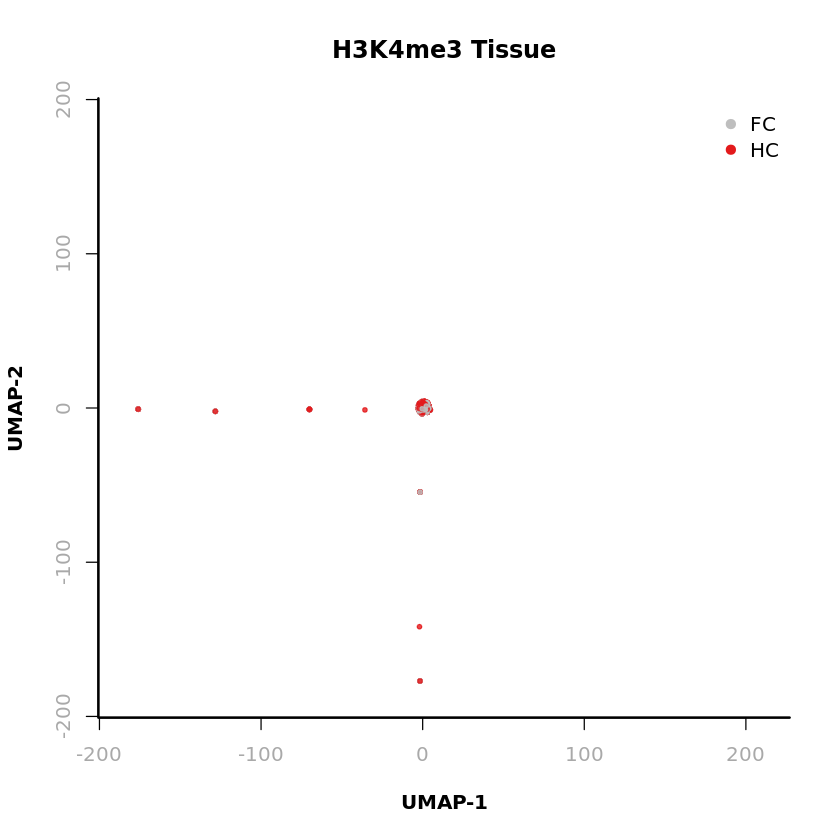

In [225]:
plotViz(
    obj=K4me3.sp,
    method="umap", 
    main="H3K4me3 Tissue",
    point.color=K4me3.sp@metaData$tissue, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

# ATAC

In [226]:
mm = readMM('example/histone/data/matrix/07.Paired-seq_DNA_filtered_matrix/matrix.mtx')
bc = read.csv('example/histone/data/matrix/07.Paired-seq_DNA_filtered_matrix/barcodes.tsv', header = FALSE)$V1
bin = GRanges(read.csv('example/histone/data/matrix/07.Paired-seq_DNA_filtered_matrix/bins.tsv', sep = '\t', header = FALSE)$V1)

In [227]:
atac.sp <- createSnapFromBmat(t(as.sparse(mm)), barcodes = bc, bins = bin)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



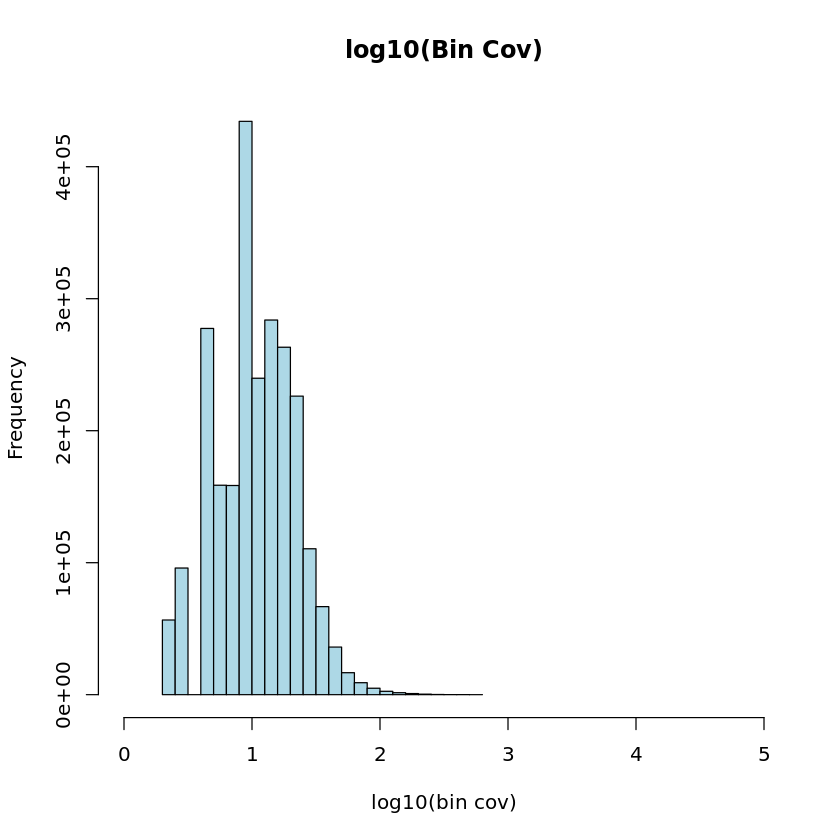

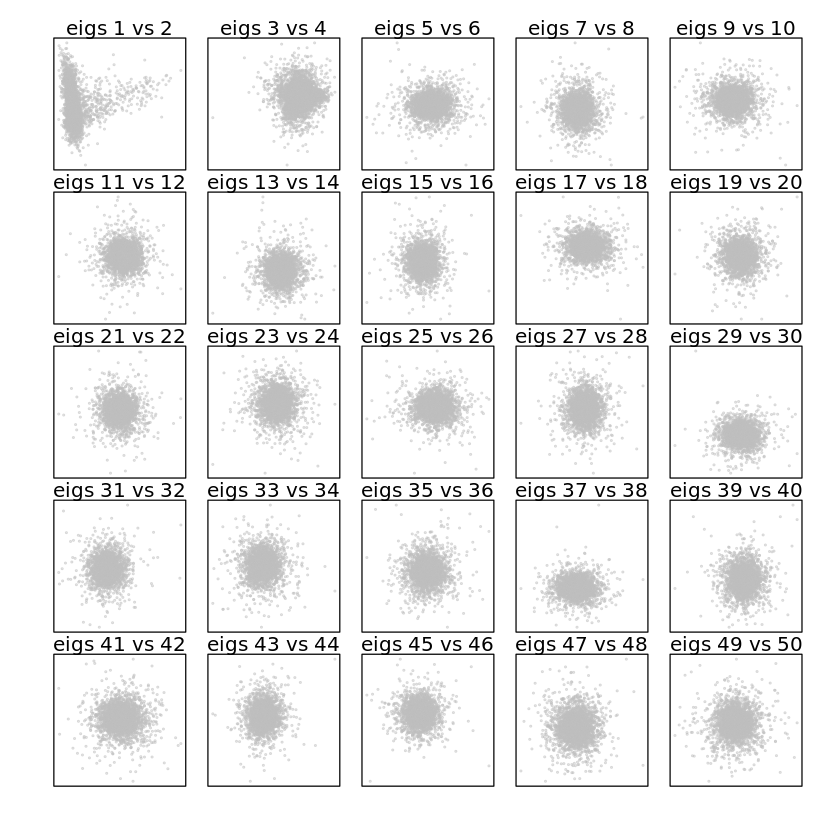

In [229]:
atac.sp <- process(atac.sp, metadata)

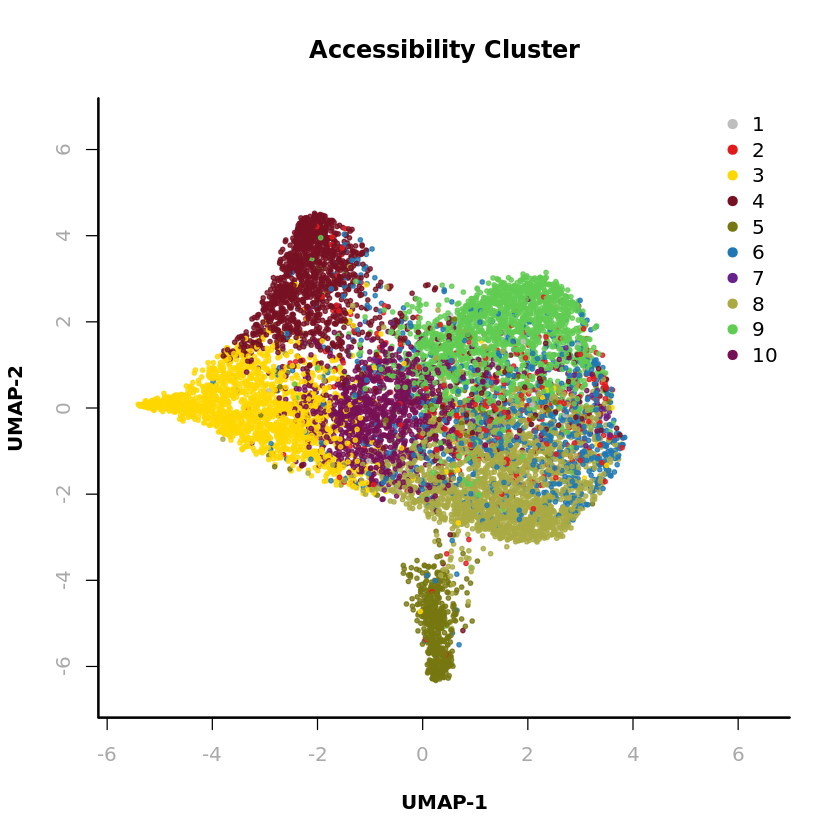

In [230]:
plotViz(
    obj=atac.sp,
    method="umap", 
    main="Accessibility Cluster",
    point.color=atac.sp@cluster, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )

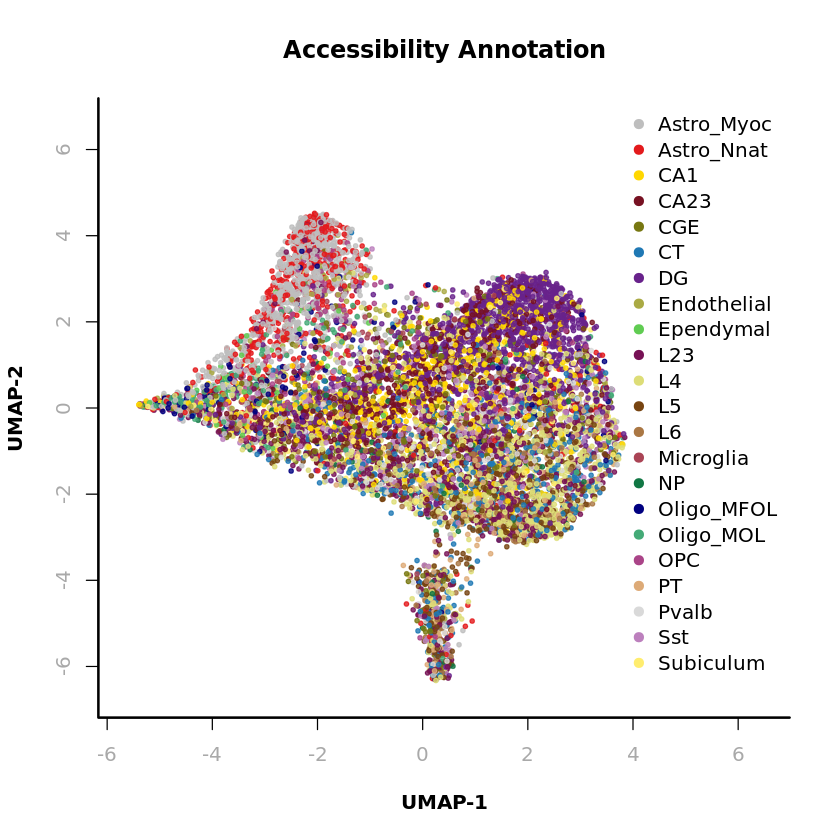

In [231]:
plotViz(
    obj=atac.sp,
    method="umap", 
    main="Accessibility Annotation",
    point.color=atac.sp@metaData$annotation, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right',
  )

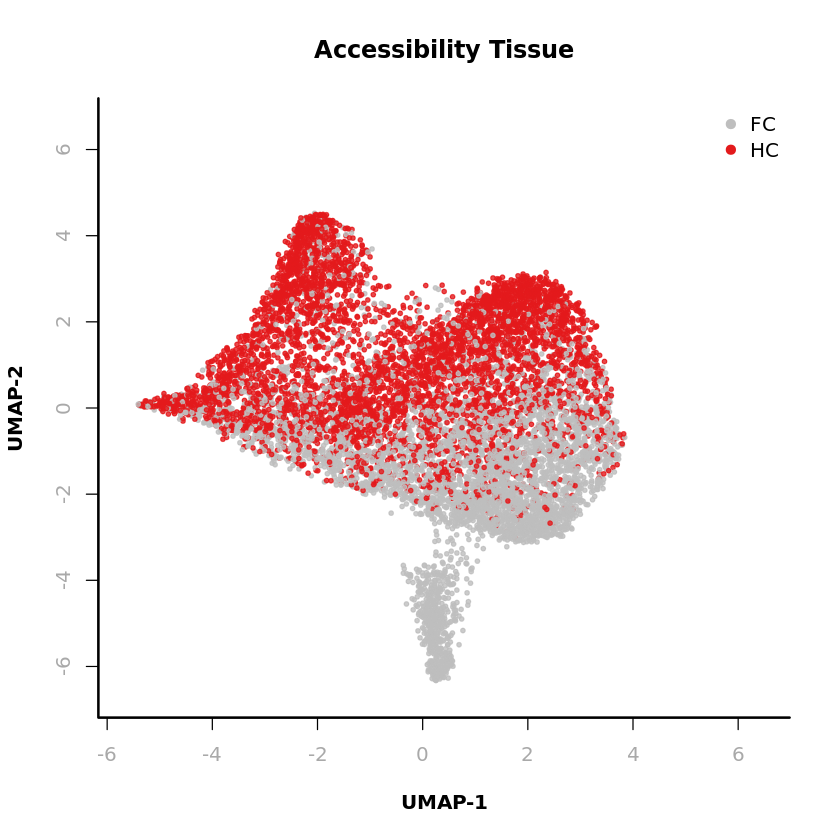

In [232]:
plotViz(
    obj=atac.sp,
    method="umap", 
    main="Accessibility Tissue",
    point.color=atac.sp@metaData$tissue, 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=FALSE,
    text.halo.color="white",
    text.halo.width=0.1,
    down.sample=10000,
    legend.add=TRUE,
    legend.pos='right'
  )